## Spatial Data Assembling

This notebook recreates the "Spatial data assembling" tutorial in Python, covering how to assemble data from different spatial formats (raster and vector) and at different supports/scales, to build a table where each sampling location has soil depth plus covariate values.

### Goal
- In this tutorial we are going to cover one common topic in spatial data analaysis: how to assamble data from different formats (e.g. raster, vector) and supports/scales.

### Motivation
Suppose we want to map the soil depth at field scale. We went to the field and measured this attribute using a tedious and time consuming manual sampling. We could not sample every part of the field but we did our best effort and distributed our sampling points trying to cover it. By the order hand, we already have some soil and landscape covariates data collected using less expensive methods. Our idea is to develop some model based on this auxiliary data in order to map soil depth. To do that, each value of soil depth have to be matched with a value of the covariates.

### Available layers 
| Name                    | Type              | Description                          |
|-------------------------|-------------------|--------------------------------------|
| `F05_boundary.gpkg`     | vector (polygon)  | field boundary                        |
| `F05_EC_2008.gpkg`      | vector (points)   | soil EC survey from 2008              |
| `F05_EC_2009.gpkg`      | vector (points)   | soil EC survey from 2009              |
| `F05_hardpan.gpkg`      | vector (points)   | soil depth (cm)                       |
| `F05_DEM_RFsp_map.grd`  | raster (multi)    | DEM and derivatives                   |

Workflow:
- Data loading and CRS checks
- Raster to points extraction (nearest, bilinear, buffered median)
- Points to points joins (intersects, nearest, within-distance aggregation)
- Interpolation (IDW, k-NN, Ordinary Kriging)
- Optional saving of outputs


In [1]:
pip install rioxarray geopandas rasterio xarray shapely

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Imports and configuration
import sys
import warnings
warnings.filterwarnings("ignore")

# Core geospatial stack
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
import rioxarray as rxr
import xarray as xr

# Data manipulation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional
# Nearest neighbor search
from scipy.spatial import cKDTree

# For spatial joins and buffers
from shapely.geometry import Point

# Optional kriging
try:
    from pykrige.ok import OrdinaryKriging
    _HAS_PYKRIGE = True
except Exception:
    _HAS_PYKRIGE = False

print("PyKrige available:", _HAS_PYKRIGE)


PyKrige available: True


### Data paths
Update the `data_dir` to the folder containing the provided layers. This notebook assumes it is run from the project directory shown in your workspace.


In [6]:
from pathlib import Path

# Use absolute path based on the workspace path
data_dir = Path("/Users/emine2/Documents/CLASSES/03_2025-FALL/TA-2025-FALL/caseStudies/soil_depth/SoilDepth_Interpolation_DataAssmbly/data")

# F05 dataset
path_boundary = data_dir / "F05_boundary.gpkg"
path_ec2008  = data_dir / "F05_EC_2008.gpkg"
path_ec2009  = data_dir / "F05_EC_2009.gpkg"
path_hpan    = data_dir / "F05_hardpan.gpkg"
path_dem_grd = data_dir / "F05_DEM_RFsp_map.grd"

for p in [path_boundary, path_ec2008, path_ec2009, path_hpan, path_dem_grd]:
    print(p, "exists:" , p.exists())


/Users/emine2/Documents/CLASSES/03_2025-FALL/TA-2025-FALL/caseStudies/soil_depth/SoilDepth_Interpolation_DataAssmbly/data/F05_boundary.gpkg exists: True
/Users/emine2/Documents/CLASSES/03_2025-FALL/TA-2025-FALL/caseStudies/soil_depth/SoilDepth_Interpolation_DataAssmbly/data/F05_EC_2008.gpkg exists: True
/Users/emine2/Documents/CLASSES/03_2025-FALL/TA-2025-FALL/caseStudies/soil_depth/SoilDepth_Interpolation_DataAssmbly/data/F05_EC_2009.gpkg exists: True
/Users/emine2/Documents/CLASSES/03_2025-FALL/TA-2025-FALL/caseStudies/soil_depth/SoilDepth_Interpolation_DataAssmbly/data/F05_hardpan.gpkg exists: True
/Users/emine2/Documents/CLASSES/03_2025-FALL/TA-2025-FALL/caseStudies/soil_depth/SoilDepth_Interpolation_DataAssmbly/data/F05_DEM_RFsp_map.grd exists: True


### Load data and inspect
We will load vector layers with GeoPandas and the raster with Rasterio. We'll also print CRS to ensure consistency.


CRS - hpan: EPSG:32721
CRS - ec2008: EPSG:32721
CRS - ec2009: EPSG:32721
CRS - boundary: EPSG:32721
CRS - dem_all: EPSG:32721


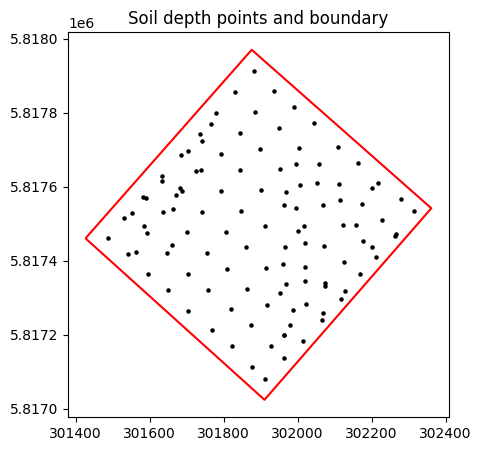

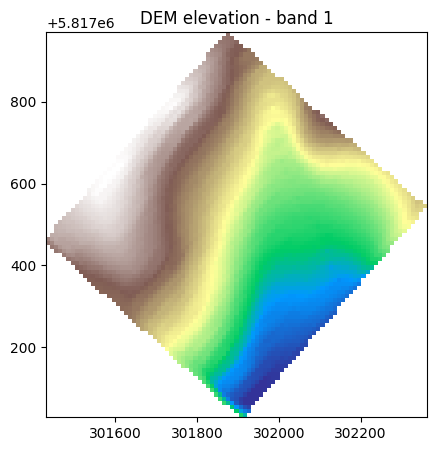

In [7]:
# Load vectors
hpan = gpd.read_file(path_hpan)
ec2008 = gpd.read_file(path_ec2008)
ec2009 = gpd.read_file(path_ec2009)
boundary = gpd.read_file(path_boundary)

# Load raster (all bands via rasterio)
with rasterio.open(path_dem_grd) as src:
    dem_all = src.read(masked=True)
    dem_elevation = dem_all[0]
    dem_transform = src.transform
    dem_crs = src.crs

print("CRS - hpan:", hpan.crs)
print("CRS - ec2008:", ec2008.crs)
print("CRS - ec2009:", ec2009.crs)
print("CRS - boundary:", boundary.crs)
print("CRS - dem_all:", dem_crs)

# Quick plots
ax = hpan.plot(figsize=(5,5), markersize=5, color='k')
boundary.boundary.plot(ax=ax, color='red')
plt.title('Soil depth points and boundary'); plt.show()

fig, ax = plt.subplots(figsize=(5,5))
show(dem_elevation, transform=dem_transform, ax=ax, cmap='terrain')
plt.title('DEM elevation - band 1'); plt.show()


In [9]:
ec2009.head()

,EC30,EC90,geometry
0,31.1,32.1,POINT (301916.239 5817065.019)
1,31.9,31.1,POINT (301916.754 5817065.586)
2,29.2,30.3,POINT (301917.443 5817066.269)
3,31.6,31.7,POINT (301918.300 5817067.289)
4,27.7,29.5,POINT (301919.415 5817068.537)


### CRS checks and harmonization
We need all layers to share a common CRS. We'll use the raster's CRS as the reference and reproject vectors as needed.


In [11]:
target_crs = dem_crs

if hpan.crs != target_crs:
    hpan = hpan.to_crs(target_crs)
if ec2008.crs != target_crs:
    ec2008 = ec2008.to_crs(target_crs)
if ec2009.crs != target_crs:
    ec2009 = ec2009.to_crs(target_crs)
if boundary.crs != target_crs:
    boundary = boundary.to_crs(target_crs)

print("All vectors reprojected to:", target_crs)


All vectors reprojected to: EPSG:32721


### Raster to points: sample values at point locations
- Nearest cell center (simple)
- Bilinear interpolation
- Buffered extraction with summary function (e.g., median)


In [12]:
hpan.head()

,hpdepth,geometry
0,101.0,POINT (302315.586 5817535.628)
1,101.0,POINT (302279.551 5817568.072)
2,101.0,POINT (302216.822 5817610.980)
3,101.0,POINT (302162.635 5817665.195)
4,101.0,POINT (302108.713 5817708.313)


## 1. Nearest cell center (Simple)

In [13]:
# 1) Simple nearest sampling from all bands (similar to R's extract(DEM_all, hpan))
coords = [(geom.x, geom.y) for geom in hpan.geometry]

with rasterio.open(path_dem_grd) as src:
    # Get band names from the raster itself
    band_names = []
    descriptions = src.descriptions or ()
    for b in range(1, src.count + 1):
        name = None
        if len(descriptions) >= b and descriptions[b - 1]:
            name = descriptions[b - 1]
        else:
            tags = src.tags(b)
            name = (
                tags.get("NAME")
                or tags.get("BandName")
                or tags.get("DESCRIPTION")
                or tags.get("desc")
                or tags.get("LAYER_NAME")
            )
        band_names.append(name if name else f"band_{b}")

    # Extract all bands at point locations
    ext_smpl = np.array(list(src.sample(coords)))  # shape: (n_points, n_bands)

    # Add all bands to hpan dataframe using the band names
    for i, col_name in enumerate(band_names):
        hpan[col_name] = ext_smpl[:, i]

hpan.head()

,hpdepth,geometry,elevation,tri,tpi,slope,aspect
0,101.0,POINT (302315.586 5817535.628),216.460007,0.309431,-0.017815,0.040508,4.500546
1,101.0,POINT (302279.551 5817568.072),215.566833,0.223083,-0.025032,0.028205,4.166702
2,101.0,POINT (302216.822 5817610.980),215.315872,0.221832,-0.008282,0.027677,3.629882
3,101.0,POINT (302162.635 5817665.195),216.625641,0.311284,0.040723,0.039090,3.199566
4,101.0,POINT (302108.713 5817708.313),218.483871,0.322072,0.029974,0.042348,3.367486


## 2. Bilinear Sampling
Another approach 'bilinear' which use interpolate the values from the 4 neighbors (rook).

In [14]:
# Bilinear (rook) interpolation from all raster bands at point locations
# get coordinates form Point Geom
coords = [(geom.x, geom.y) for geom in hpan.geometry]

with rasterio.open(path_dem_grd) as src:
    # Band names from the raster itself
    band_names = []
    descriptions = src.descriptions or ()
    for b in range(1, src.count + 1):
        nm = None
        if len(descriptions) >= b and descriptions[b - 1]:
            nm = descriptions[b - 1]
        else:
            tags = src.tags(b)
            nm = (
                tags.get("NAME")
                or tags.get("BandName")
                or tags.get("DESCRIPTION")
                or tags.get("desc")
                or tags.get("LAYER_NAME")
            )
        band_names.append(nm if nm else f"band_{b}")

    inv_transform = ~src.transform
    width, height = src.width, src.height
    # create an empty array to stire interpolated results
    # rows = number of points, columns = number of raster bands
    ext_bil_arr = np.full((len(coords), src.count), np.nan, dtype="float64")
    # loop over each point
    for i, (x, y) in enumerate(coords):
        colf, rowf = inv_transform * (x, y)
        r0 = int(np.floor(rowf))
        c0 = int(np.floor(colf))
        r1 = r0 + 1
        c1 = c0 + 1

        # Skip points that cannot form a full 2x2 neighborhood
        if r0 < 0 or c0 < 0 or r1 >= height or c1 >= width:
            continue
        # Compute interpolation weights (bilinear equation)
        dx = colf - c0
        dy = rowf - r0

        w00 = (1.0 - dx) * (1.0 - dy)  # top-left
        w10 = dx * (1.0 - dy)          # top-right
        w01 = (1.0 - dx) * dy          # bottom-left
        w11 = dx * dy                  # bottom-right
        # Read the 2x2 window of raster values
        window = rasterio.windows.Window(c0, r0, 2, 2)
        block = src.read(indexes=list(range(1, src.count + 1)), window=window, masked=True)  # (bands, 2, 2)
        # Apply bilinear interpolation formula
        val = (block[:, 0, 0] * w00 +
               block[:, 0, 1] * w10 +
               block[:, 1, 0] * w01 +
               block[:, 1, 1] * w11)
        # Store the interpolated values
        ext_bil_arr[i, :] = np.ma.filled(val, np.nan)

# Write bilinear values into hpan with suffixed column names
for j, base_name in enumerate(band_names):
    hpan[f"{base_name}_bilinear"] = ext_bil_arr[:, j]
# Optional: also keep a DataFrame view with suffixed names
ext_bil = pd.DataFrame(ext_bil_arr, columns=[f"{n}_bilinear" for n in band_names])
hpan.head()

,hpdepth,geometry,elevation,tri,tpi,slope,aspect,elevation_bilinear,tri_bilinear,tpi_bilinear,slope_bilinear,aspect_bilinear
0,101.0,POINT (302315.586 5817535.628),216.460007,0.309431,-0.017815,0.040508,4.500546,216.596100,0.285485,0.062387,0.035644,4.341960
1,101.0,POINT (302279.551 5817568.072),215.566833,0.223083,-0.025032,0.028205,4.166702,215.745956,0.245043,-0.033456,0.031449,4.229860
2,101.0,POINT (302216.822 5817610.980),215.315872,0.221832,-0.008282,0.027677,3.629882,215.162888,0.194429,-0.043002,0.025387,3.679813
3,101.0,POINT (302162.635 5817665.195),216.625641,0.311284,0.040723,0.039090,3.199566,216.429993,0.305804,-0.000083,0.038794,3.161847
4,101.0,POINT (302108.713 5817708.313),218.483871,0.322072,0.029974,0.042348,3.367486,218.489120,0.322508,0.045280,0.041147,3.263089


## 3. Buffered Extraction
More complex approaches can be used. For example, for taking the median values from the points within a search radious of 20 m.

In [15]:
# Buffered median (20 m) from all raster bands at point locations
buffer_radius = 20.0  # meters
coords = [(geom.x, geom.y) for geom in hpan.geometry]

with rasterio.open(path_dem_grd) as src:
    # Band names from raster metadata
    band_names = []
    descriptions = src.descriptions or ()
    for b in range(1, src.count + 1):
        nm = None
        if len(descriptions) >= b and descriptions[b - 1]:
            nm = descriptions[b - 1]
        else:
            tags = src.tags(b)
            nm = (
                tags.get("NAME")
                or tags.get("BandName")
                or tags.get("DESCRIPTION")
                or tags.get("desc")
                or tags.get("LAYER_NAME")
            )
        band_names.append(nm if nm else f"band_{b}")
    # Convert Coordinates & Buffer into Pixel Units
    transform = src.transform
    inv_transform = ~transform

    # Pixel sizes (robust to rotation)
    # Converts 20m buffer to raster pixels.
    # For example, if pixel size is 10m → 20m buffer = 2 pixels.
    res_x = np.hypot(transform.a, transform.d)
    res_y = np.hypot(transform.b, transform.e)
    rad_cols = int(np.ceil(buffer_radius / max(res_x, 1e-9)))
    rad_rows = int(np.ceil(buffer_radius / max(res_y, 1e-9)))

    height, width = src.height, src.width
    ext_buf_arr = np.full((len(coords), src.count), np.nan, dtype="float64")
    # loop over each point
    for i, (x, y) in enumerate(coords):
        colf, rowf = inv_transform * (x, y)
        c0 = int(np.floor(colf))
        r0 = int(np.floor(rowf))

        minc = max(0, c0 - rad_cols)
        maxc = min(width, c0 + rad_cols + 1)
        minr = max(0, r0 - rad_rows)
        maxr = min(height, r0 + rad_rows + 1) 

        if minc >= maxc or minr >= maxr:
            continue
        # Read Raster Block and Compute Circular Mask
        window = rasterio.windows.Window(minc, minr, maxc - minc, maxr - minr)
        block = src.read(indexes=list(range(1, src.count + 1)), window=window, masked=True)  # (bands, h, w)

        rows = np.arange(minr, maxr)
        cols = np.arange(minc, maxc)
        rr, cc = np.meshgrid(rows, cols, indexing="ij")

        # Pixel centers in map units
        xw = transform.c + transform.a * (cc + 0.5) + transform.b * (rr + 0.5)
        yw = transform.f + transform.d * (cc + 0.5) + transform.e * (rr + 0.5)

        inside = ((xw - x) ** 2 + (yw - y) ** 2) <= (buffer_radius ** 2)
        if not np.any(inside):
            continue
        # Compute Median for Each Band
        for j in range(src.count):
            # Fill masked values with NaN and compute median within the circular buffer
            vals = np.ma.filled(block[j], np.nan)[inside]
            if vals.size == 0 or np.all(np.isnan(vals)):
                ext_buf_arr[i, j] = np.nan
            else:
                ext_buf_arr[i, j] = float(np.nanmedian(vals))

# Write buffered medians into hpan with suffixed names
for j, base_name in enumerate(band_names):
    hpan[f"{base_name}_buffer"] = ext_buf_arr[:, j]

hpan.head()

,hpdepth,geometry,elevation,tri,tpi,slope,aspect,elevation_bilinear,tri_bilinear,tpi_bilinear,slope_bilinear,aspect_bilinear,elevation_buffer,tri_buffer,tpi_buffer,slope_buffer,aspect_buffer
0,101.0,POINT (302315.586 5817535.628),216.460007,0.309431,-0.017815,0.040508,4.500546,216.596100,0.285485,0.062387,0.035644,4.341960,216.460007,0.285723,-0.005529,0.036790,4.420410
1,101.0,POINT (302279.551 5817568.072),215.566833,0.223083,-0.025032,0.028205,4.166702,215.745956,0.245043,-0.033456,0.031449,4.229860,215.744034,0.247856,-0.019697,0.031675,4.182882
2,101.0,POINT (302216.822 5817610.980),215.315872,0.221832,-0.008282,0.027677,3.629882,215.162888,0.194429,-0.043002,0.025387,3.679813,215.175507,0.202148,-0.010989,0.025841,3.637171
3,101.0,POINT (302162.635 5817665.195),216.625641,0.311284,0.040723,0.039090,3.199566,216.429993,0.305804,-0.000083,0.038794,3.161847,216.613403,0.325459,-0.032622,0.041423,3.101039
4,101.0,POINT (302108.713 5817708.313),218.483871,0.322072,0.029974,0.042348,3.367486,218.489120,0.322508,0.045280,0.041147,3.263089,218.646149,0.307821,0.035342,0.039099,3.375623


### Plot raster and points together


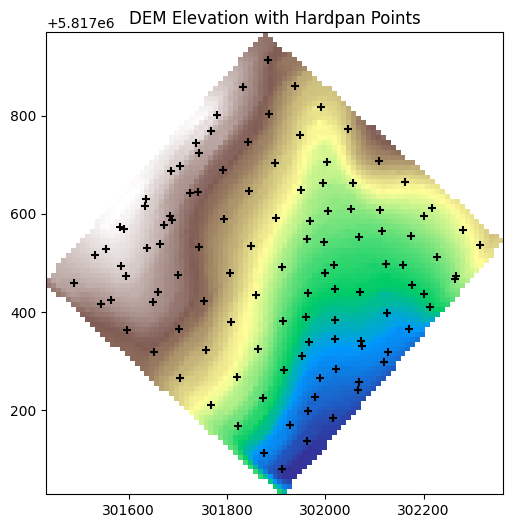

In [16]:
# Plot DEM elevation raster
with rasterio.open(path_dem_grd) as src:
    fig, ax = plt.subplots(figsize=(8, 6))
    show(src, ax=ax, cmap='terrain')
    # Overlay hardpan points
    hpan.plot(ax=ax, color='black', markersize=30, marker='+')
    plt.title('DEM Elevation with Hardpan Points')
    plt.show()


### Points to points joins
Options shown:
1. Spatial join with intersects (may miss non-coincident points)
2.  Nearest feature join
3.  Within-distance join and aggregation (e.g., mean EC30/EC90 within 5–10 m)


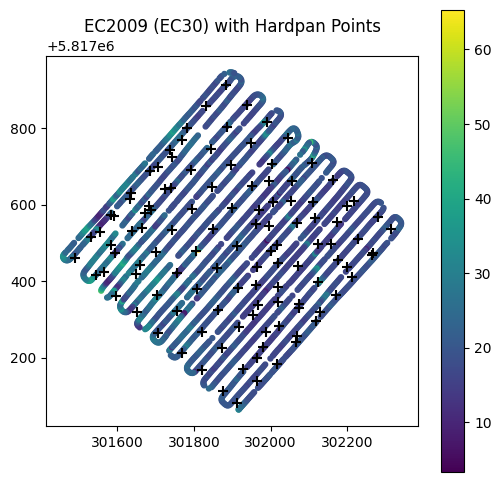

In [17]:
# Plot EC2009 (first numeric attribute if available) and overlay hpan points as '+'
non_geom_cols = [c for c in ec2009.columns if c != ec2009.geometry.name]
num_cols = ec2009[non_geom_cols].select_dtypes(include=[np.number]).columns.tolist()
col_to_plot = num_cols[0] if len(num_cols) else None

fig, ax = plt.subplots(figsize=(6, 6))
if col_to_plot:
    ec2009.plot(column=col_to_plot, legend=True, cmap="viridis", markersize=12, ax=ax)
    ax.set_title(f"EC2009 ({col_to_plot}) with Hardpan Points")
else:
    ec2009.plot(color="tab:blue", markersize=12, ax=ax)
    ax.set_title("EC2009 with Hardpan Points")

hpan.plot(ax=ax, color="black", markersize=60, marker="+")
ax.set_aspect("equal")
plt.show()

## 1. Intersects - Spatial Join 
It consists in doing a left join of features using gpd.sjoin(). Depending on the join arguments, sjoin will create an index for each feature in both dataset based on their location. The default option is to assing the features of the left object those attributes from the features of the right object that are exactly collocated.




In [18]:
# 1) Intersects (exactly coincident)
try:
    joined_intersects = gpd.sjoin(hpan, ec2009, predicate="intersects", how="left")
except TypeError:
    # For older geopandas versions
    joined_intersects = gpd.sjoin(hpan, ec2009, op="intersects", how="left")

joined_intersects.head()


,hpdepth,geometry,elevation,tri,tpi,slope,aspect,elevation_bilinear,tri_bilinear,tpi_bilinear,slope_bilinear,aspect_bilinear,elevation_buffer,tri_buffer,tpi_buffer,slope_buffer,aspect_buffer,index_right,EC30,EC90
0,101.0,POINT (302315.586 5817535.628),216.460007,0.309431,-0.017815,0.040508,4.500546,216.596100,0.285485,0.062387,0.035644,4.341960,216.460007,0.285723,-0.005529,0.036790,4.420410,NaN,NaN,NaN
1,101.0,POINT (302279.551 5817568.072),215.566833,0.223083,-0.025032,0.028205,4.166702,215.745956,0.245043,-0.033456,0.031449,4.229860,215.744034,0.247856,-0.019697,0.031675,4.182882,NaN,NaN,NaN
2,101.0,POINT (302216.822 5817610.980),215.315872,0.221832,-0.008282,0.027677,3.629882,215.162888,0.194429,-0.043002,0.025387,3.679813,215.175507,0.202148,-0.010989,0.025841,3.637171,NaN,NaN,NaN
3,101.0,POINT (302162.635 5817665.195),216.625641,0.311284,0.040723,0.039090,3.199566,216.429993,0.305804,-0.000083,0.038794,3.161847,216.613403,0.325459,-0.032622,0.041423,3.101039,NaN,NaN,NaN
4,101.0,POINT (302108.713 5817708.313),218.483871,0.322072,0.029974,0.042348,3.367486,218.489120,0.322508,0.045280,0.041147,3.263089,218.646149,0.307821,0.035342,0.039099,3.375623,NaN,NaN,NaN


## 2. Nearest feature join

As we can see from the output, several points of the hpan object got a NaN values for EC30 and EC90 as the did not coincided with points from EC2009. To avoid this issue, we can use different apporaches for points-to-points joins.

In [19]:
# 2) Nearest feature join (1:1)
def nearest_join(left: gpd.GeoDataFrame, right: gpd.GeoDataFrame, right_on_cols):
    left_centroids = np.vstack([left.geometry.x.values, left.geometry.y.values]).T # Extracts X and Y coordinates from left GeoDataFrame (hpan) into an array.
    right_centroids = np.vstack([right.geometry.x.values, right.geometry.y.values]).T # Same thing for right GeoDataFrame (ec2009).
    tree = cKDTree(right_centroids) # Builds a super fast spatial index using SciPy’s KDTree.
    dist, idx = tree.query(left_centroids, k=1) # Finds the nearest point in right GeoDataFrame for each point in left GeoDataFrame.
    right_sel = right.reset_index(drop=True).iloc[idx][right_on_cols].reset_index(drop=True) # Selects the columns of interest from the right GeoDataFrame.
    out = left.reset_index(drop=True).join(right_sel) # Joins the selected columns with the left GeoDataFrame.
    out["nearest_dist_m"] = dist # Adds the distance to the nearest point in the right GeoDataFrame.
    return out

# Select EC columns to bring over (if present)
ec_cols = [c for c in ec2009.columns if c.lower() in ("ec30", "ec90")]
if not ec_cols:
    # fallback: try common names
    ec_cols = [c for c in ec2009.columns if "EC" in c.upper()]

hpan_nearest = nearest_join(hpan, ec2009, right_on_cols=ec_cols)
hpan_nearest.head()

,hpdepth,geometry,elevation,tri,tpi,slope,aspect,elevation_bilinear,tri_bilinear,tpi_bilinear,slope_bilinear,aspect_bilinear,elevation_buffer,tri_buffer,tpi_buffer,slope_buffer,aspect_buffer,EC30,EC90,nearest_dist_m
0,101.0,POINT (302315.586 5817535.628),216.460007,0.309431,-0.017815,0.040508,4.500546,216.596100,0.285485,0.062387,0.035644,4.341960,216.460007,0.285723,-0.005529,0.036790,4.420410,17.0,19.0,14.341959
1,101.0,POINT (302279.551 5817568.072),215.566833,0.223083,-0.025032,0.028205,4.166702,215.745956,0.245043,-0.033456,0.031449,4.229860,215.744034,0.247856,-0.019697,0.031675,4.182882,15.3,15.9,2.558400
2,101.0,POINT (302216.822 5817610.980),215.315872,0.221832,-0.008282,0.027677,3.629882,215.162888,0.194429,-0.043002,0.025387,3.679813,215.175507,0.202148,-0.010989,0.025841,3.637171,16.3,12.9,15.128248
3,101.0,POINT (302162.635 5817665.195),216.625641,0.311284,0.040723,0.039090,3.199566,216.429993,0.305804,-0.000083,0.038794,3.161847,216.613403,0.325459,-0.032622,0.041423,3.101039,16.7,21.5,1.919052
4,101.0,POINT (302108.713 5817708.313),218.483871,0.322072,0.029974,0.042348,3.367486,218.489120,0.322508,0.045280,0.041147,3.263089,218.646149,0.307821,0.035342,0.039099,3.375623,18.7,26.7,9.652717


## 3. Within Distance Join 

In [20]:
# 3) Within-distance join and aggregation
search_radius = 10.0  # meters

# Build buffers
hpan_buf = hpan.copy()
hpan_buf["buffer_geom"] = hpan_buf.geometry.buffer(search_radius)

# Spatial index for ec2009
# Spatial index helps quickly find candidate features near a geometry — much faster than checking all points.
ec_sindex = ec2009.sindex

# Loop Through Each hpan Buffer and Check for EC2009 Points Inside
agg_results = []
for i, buf in enumerate(hpan_buf["buffer_geom"]):
    # candidate indices
    # Identify candidate EC points using bounding box
    candidate_idx = list(ec_sindex.intersection(buf.bounds))
    candidates = ec2009.iloc[candidate_idx]
    # Filter candidates that actually intersect with the buffer 
    inside = candidates[candidates.intersects(buf)]
    if inside.empty: # No EC2009 points inside → return NaN and zero count.
        agg_results.append({"EC30_mean": np.nan, "EC90_mean": np.nan, "n_pts": 0})
    # if found --> ompute mean EC30 and mean EC90.
    else:
        vals = {}
        if "EC30" in inside.columns:
            vals["EC30_mean"] = inside["EC30"].astype(float).mean()
        else:
            vals["EC30_mean"] = np.nan
        if "EC90" in inside.columns:
            vals["EC90_mean"] = inside["EC90"].astype(float).mean()
        else:
            vals["EC90_mean"] = np.nan
        vals["n_pts"] = len(inside)
        agg_results.append(vals)

agg_df = pd.DataFrame(agg_results)
hpan_within_agg = hpan.reset_index(drop=True).join(agg_df)

hpan_within_agg.head()

,hpdepth,geometry,elevation,tri,tpi,slope,aspect,elevation_bilinear,tri_bilinear,tpi_bilinear,slope_bilinear,aspect_bilinear,elevation_buffer,tri_buffer,tpi_buffer,slope_buffer,aspect_buffer,EC30_mean,EC90_mean,n_pts
0,101.0,POINT (302315.586 5817535.628),216.460007,0.309431,-0.017815,0.040508,4.500546,216.596100,0.285485,0.062387,0.035644,4.341960,216.460007,0.285723,-0.005529,0.036790,4.420410,NaN,NaN,0
1,101.0,POINT (302279.551 5817568.072),215.566833,0.223083,-0.025032,0.028205,4.166702,215.745956,0.245043,-0.033456,0.031449,4.229860,215.744034,0.247856,-0.019697,0.031675,4.182882,16.60,18.1,4
2,101.0,POINT (302216.822 5817610.980),215.315872,0.221832,-0.008282,0.027677,3.629882,215.162888,0.194429,-0.043002,0.025387,3.679813,215.175507,0.202148,-0.010989,0.025841,3.637171,NaN,NaN,0
3,101.0,POINT (302162.635 5817665.195),216.625641,0.311284,0.040723,0.039090,3.199566,216.429993,0.305804,-0.000083,0.038794,3.161847,216.613403,0.325459,-0.032622,0.041423,3.101039,16.65,21.5,2
4,101.0,POINT (302108.713 5817708.313),218.483871,0.322072,0.029974,0.042348,3.367486,218.489120,0.322508,0.045280,0.041147,3.263089,218.646149,0.307821,0.035342,0.039099,3.375623,18.70,26.7,1
